In [138]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn   # neural network modules
import torch.optim as optim   # optimization algorithms
import torch.nn.functional as F   # functions without parameters like activation functions
from torch.utils.data import TensorDataset, DataLoader   # dataset management, create batches
import torchvision.datasets as datasets   # standard datasets on pytorch
import torchvision.transforms as transforms   #transform datasets

import matplotlib.pyplot as plt

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [139]:
train_dataset = pd.read_csv("train.csv")

print(f"Full train dataset shape is {train_dataset.shape}")

Full train dataset shape is (8693, 14)


In [140]:
#examine dataset
train_dataset.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [141]:
train_dataset.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


<Axes: >

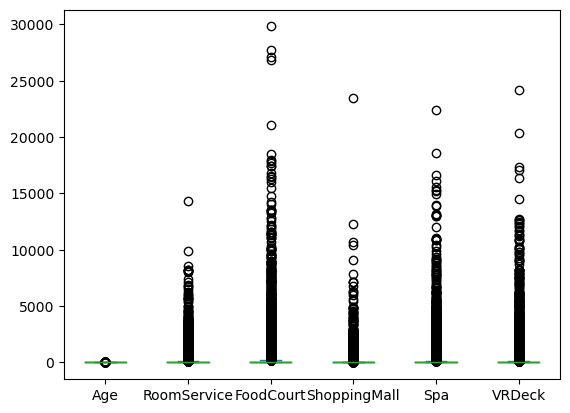

In [142]:
train_dataset.plot(kind='box')

In [143]:
#drop id and name columns as they are not important
train_dataset = train_dataset.drop(['PassengerId', 'Name'], axis=1)

In [144]:
'''
#replace nan values with 0
train_dataset.isnull().sum().sort_values(ascending=False)
train_dataset[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','HomePlanet','Destination']] = train_dataset[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','HomePlanet','Destination']].fillna(value=0)


# replace nan values with mode
replacements = train_dataset[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','HomePlanet','Destination']].mode()
print(replacements)
train_dataset[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','HomePlanet','Destination']] = train_dataset[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','HomePlanet','Destination']].fillna(replacements)
'''

train_dataset = train_dataset.fillna(train_dataset.mode().iloc[0])


In [145]:
train_dataset.isnull().sum().sort_values(ascending=False)

HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
dtype: int64

In [146]:
#replace cabin number with 3 different columns
train_dataset[['Deck', 'Cabin_num', 'Side']] = train_dataset['Cabin'].str.split("/", expand=True)
train_dataset = train_dataset.drop('Cabin', axis=1)

In [147]:
print(train_dataset['Deck'].unique())
print(train_dataset['Cabin_num'].unique())
print(train_dataset['Side'].unique())

['B' 'F' 'A' 'G' 'E' 'D' 'C' 'T']
['0' '1' '2' ... '1892' '1893' '1894']
['P' 'S']


In [148]:
train_dataset.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Cabin_num,Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1,S


In [149]:
train_dataset.dtypes

HomePlanet       object
CryoSleep          bool
Destination      object
Age             float64
VIP                bool
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Transported        bool
Deck             object
Cabin_num        object
Side             object
dtype: object

In [150]:
train_dataset['Cabin_num'] = train_dataset['Cabin_num'].astype('int16')

In [151]:
train_dataset.dtypes

HomePlanet       object
CryoSleep          bool
Destination      object
Age             float64
VIP                bool
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Transported        bool
Deck             object
Cabin_num         int16
Side             object
dtype: object

In [152]:
#enc_train = pd.get_dummies(train_dataset, prefix = ['HomePlanet','Destination','Deck','Side'])
enc_train = pd.get_dummies(train_dataset, prefix = ['HomePlanet','Destination','Deck','Side'])
enc_train.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin_num,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,False,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0,...,0,1,0,0,0,0,0,0,1,0
1,False,24.0,False,109.0,9.0,25.0,549.0,44.0,True,0,...,0,0,0,0,0,1,0,0,0,1
2,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,0,...,1,0,0,0,0,0,0,0,0,1
3,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,0,...,1,0,0,0,0,0,0,0,0,1
4,False,16.0,False,303.0,70.0,151.0,565.0,2.0,True,1,...,0,0,0,0,0,1,0,0,0,1


In [153]:
print(enc_train.shape)
print(enc_train['RoomService'].value_counts())
print(enc_train['FoodCourt'].value_counts())
print(enc_train['ShoppingMall'].value_counts())
print(enc_train['Spa'].value_counts())
print(enc_train['VRDeck'].value_counts())

(8693, 26)
0.0       5758
1.0        117
2.0         79
3.0         61
4.0         47
          ... 
1612.0       1
2598.0       1
632.0        1
378.0        1
745.0        1
Name: RoomService, Length: 1273, dtype: int64
0.0       5639
1.0        116
2.0         75
3.0         53
4.0         53
          ... 
3846.0       1
5193.0       1
312.0        1
827.0        1
4688.0       1
Name: FoodCourt, Length: 1507, dtype: int64
0.0       5795
1.0        153
2.0         80
3.0         59
4.0         45
          ... 
3627.0       1
2074.0       1
871.0        1
742.0        1
1872.0       1
Name: ShoppingMall, Length: 1115, dtype: int64
0.0       5507
1.0        146
2.0        105
5.0         53
3.0         53
          ... 
273.0        1
2581.0       1
2948.0       1
3778.0       1
1643.0       1
Name: Spa, Length: 1327, dtype: int64
0.0       5683
1.0        139
2.0         70
3.0         56
5.0         51
          ... 
408.0        1
876.0        1
2891.0       1
2102.0       1
3235

In [154]:
# remove outliers

# remove using z-score
from scipy import stats

z_RoomService = np.abs(stats.zscore(enc_train['RoomService']))
z_FoodCourt = np.abs(stats.zscore(enc_train['FoodCourt']))
z_ShoppingMall = np.abs(stats.zscore(enc_train['ShoppingMall']))
z_Spa = np.abs(stats.zscore(enc_train['Spa']))
z_VRDeck = np.abs(stats.zscore(enc_train['VRDeck']))

z_data = [z_RoomService,z_FoodCourt,z_ShoppingMall,z_Spa,z_VRDeck]
z_list = []
for x in z_data:
    z_list.extend(np.where(x>3)[0].flatten().tolist())

print(len(z_list))
enc_train = enc_train.drop(index = z_list, axis=0)

enc_train = pd.DataFrame(enc_train)
print(enc_train.shape)


'''
# remove using IQR
iqr_datasets = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
remove_list = []

for x in iqr_datasets:
    Q1 = np.percentile(enc_train[x], 25, method='midpoint')
    Q3 = np.percentile(enc_train[x], 75, method='midpoint')
    IQR = Q3 - Q1

    upper=Q3+1.5*IQR
    lower=Q1-1.5*IQR

    remove_list.extend(np.where(enc_train[x]>=upper)[0].flatten().tolist())
    remove_list.extend(np.where(enc_train[x]<=lower)[0].flatten().tolist())

enc_train = enc_train.drop(index = remove_list, axis=0)
print(enc_train.shape)

'''


814
(7961, 26)


"\n# remove using IQR\niqr_datasets = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']\nremove_list = []\n\nfor x in iqr_datasets:\n    Q1 = np.percentile(enc_train[x], 25, method='midpoint')\n    Q3 = np.percentile(enc_train[x], 75, method='midpoint')\n    IQR = Q3 - Q1\n\n    upper=Q3+1.5*IQR\n    lower=Q1-1.5*IQR\n\n    remove_list.extend(np.where(enc_train[x]>=upper)[0].flatten().tolist())\n    remove_list.extend(np.where(enc_train[x]<=lower)[0].flatten().tolist())\n\nenc_train = enc_train.drop(index = remove_list, axis=0)\nprint(enc_train.shape)\n\n"

In [155]:
# normalize data

from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler, normalize

# using scalers

# Select the columns to be normalized
cols_to_normalize = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Create a scaler object
#scaler = StandardScaler()
#scaler = MaxAbsScaler()
scaler = MinMaxScaler()

# Fit the scaler to the selected columns
scaler.fit(enc_train[cols_to_normalize])

# Transform the selected columns
enc_train[cols_to_normalize] = scaler.transform(enc_train[cols_to_normalize])

# convert back to dataframe from array
enc_train = pd.DataFrame(enc_train)

'''
# using normalize function 

# select the columns to be normalized
cols_to_normalize = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# normalize the selected columns
enc_train[cols_to_normalize] = normalize(enc_train[cols_to_normalize])
'''

print(enc_train.head())

   CryoSleep       Age    VIP  RoomService  FoodCourt  ShoppingMall       Spa  \
0      False  0.493671  False     0.000000   0.000000      0.000000  0.000000   
1      False  0.303797  False     0.049749   0.001722      0.012807  0.149673   
3      False  0.417722  False     0.000000   0.245550      0.190061  0.907579   
4      False  0.202532  False     0.138293   0.013397      0.077357  0.154035   
5      False  0.556962  False     0.000000   0.092440      0.000000  0.079335   

     VRDeck  Transported  Cabin_num  ...  Deck_A  Deck_B  Deck_C  Deck_D  \
0  0.000000        False          0  ...       0       1       0       0   
1  0.011908         True          0  ...       0       0       0       0   
3  0.052233        False          0  ...       1       0       0       0   
4  0.000541         True          1  ...       0       0       0       0   
5  0.000000         True          0  ...       0       0       0       0   

   Deck_E  Deck_F  Deck_G  Deck_T  Side_P  Side_S  
0   

In [156]:
target = 'Transported'
enc_train[target] = enc_train[target].astype('int16')
enc_train['VIP'] = enc_train['VIP'].astype('int16')
enc_train['CryoSleep'] = enc_train['CryoSleep'].astype('int16')

In [157]:
print(enc_train.dtypes)

CryoSleep                      int16
Age                          float64
VIP                            int16
RoomService                  float64
FoodCourt                    float64
ShoppingMall                 float64
Spa                          float64
VRDeck                       float64
Transported                    int16
Cabin_num                      int16
HomePlanet_Earth               uint8
HomePlanet_Europa              uint8
HomePlanet_Mars                uint8
Destination_55 Cancri e        uint8
Destination_PSO J318.5-22      uint8
Destination_TRAPPIST-1e        uint8
Deck_A                         uint8
Deck_B                         uint8
Deck_C                         uint8
Deck_D                         uint8
Deck_E                         uint8
Deck_F                         uint8
Deck_G                         uint8
Deck_T                         uint8
Side_P                         uint8
Side_S                         uint8
dtype: object


In [158]:
#train and val split
train_df = enc_train.sample(frac=0.8, random_state=123)
val_df = enc_train.drop(train_df.index)


In [159]:
#convert to tensors
train_x = torch.tensor(train_df.drop("Transported", axis=1).values, dtype=torch.float32)
train_y = torch.tensor(train_df["Transported"].values, dtype=torch.float32)
val_x = torch.tensor(val_df.drop("Transported", axis=1).values, dtype=torch.float32)
val_y = torch.tensor(val_df["Transported"].values, dtype=torch.float32)

train_dataset = TensorDataset(train_x, train_y)
val_dataset = TensorDataset(val_x, val_y)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [160]:
# hyperparameters
input_size = train_x.shape[1]
num_classes = 1 #if probability greater than 0.5, then True, if less then False
learning_rate = 0.001  

In [161]:
class NN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NN,self).__init__()
        self.fc1 = nn.Linear(input_size, 100)
        self.fc2 = nn.Linear(100,50)
        self.fc3 = nn.Linear(50, num_classes)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

In [162]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = NN(input_size=input_size, num_classes=num_classes).to(device)

criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)  

In [163]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of iter(training_loader) so that we can track the batch index and do some intra-epoch reporting
    for index, data in enumerate(train_loader):

        # Every data instance is an input + label pair
        batch_x, batch_y = data
        
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(batch_x)

        # Compute the loss and its gradients
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item() #retrieves the scalar value of the loss function for the current batch
        if index % 10 == 9: #reports on loss every 10 batches
            last_loss = running_loss / 10 # loss per batch
            print(f'  batch {index + 1} loss: {last_loss}')
            tb_x = epoch_index * len(train_loader) + index + 1  #variable is used to set the x-axis value for the scalar summary in TensorBoard, based on the current epoch and batch index
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0

    return last_loss #last calculated batch loss

In [164]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/spaceship_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 300

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for index, vdata in enumerate(val_loader):
        vbatch_x, vbatch_y = vdata
        voutputs = model(vbatch_x)
        vloss = criterion(voutputs.squeeze(), vbatch_y)
        running_vloss += vloss

    avg_vloss = running_vloss / (index + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 10 loss: 1.1874179065227508
  batch 20 loss: 0.8787496387958527
  batch 30 loss: 0.7778638362884521
  batch 40 loss: 0.7047982573509216
  batch 50 loss: 0.7083860516548157
  batch 60 loss: 0.700305563211441
  batch 70 loss: 0.7226896464824677
  batch 80 loss: 0.707354599237442
  batch 90 loss: 0.6907331645488739
  batch 100 loss: 0.6941485285758973
LOSS train 0.6941485285758973 valid 0.7240931987762451
EPOCH 2:
  batch 10 loss: 0.8048691332340241
  batch 20 loss: 0.7005672574043273
  batch 30 loss: 0.708374410867691
  batch 40 loss: 0.718606299161911
  batch 50 loss: 0.6777041256427765
  batch 60 loss: 0.6621282041072846
  batch 70 loss: 0.6515026152133941
  batch 80 loss: 0.700490003824234
  batch 90 loss: 0.7206288337707519
  batch 100 loss: 0.7798356175422668
LOSS train 0.7798356175422668 valid 0.6834011673927307
EPOCH 3:
  batch 10 loss: 0.6661130785942078
  batch 20 loss: 0.6573908150196075
  batch 30 loss: 0.660956734418869
  batch 40 loss: 0.6233744859695435
  b

In [165]:
def check_accuracy(loader,model): 
    if loader == train_loader: 
        print("checking accuracy on training data")
    else:
        print("checking accuracy on test data")
    num_correct = 0
    num_samples = 0
    model.eval() 
    
    with torch.no_grad(): 
        for x,y in loader:
            x= x.to(device=device)
            y= y.to(device=device)
            
            outputs = model(x)
            probs = outputs.squeeze() 
            preds = (probs > 0.5).to(torch.float32)
            
            num_correct += (preds == y).sum()
            num_samples += x.shape[0]
            
        print(f'{num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')   #2dp
        
    model.train()

In [166]:
check_accuracy(train_loader,model)
check_accuracy(val_loader,model)

checking accuracy on training data
4369 / 6369 with accuracy 68.60
checking accuracy on test data
1091 / 1592 with accuracy 68.53
